# Custom Gym Environment for Dynamic Pricing

**Purpose:** Create a custom OpenAI Gym environment that simulates the dynamic pricing market.

**What we'll do:**
1. Define the `DynamicPricingEnv` class
2. Set up observation and action spaces
3. Implement step() and reset() functions
4. Define the reward function (revenue = price × demand)
5. Test the environment with random actions

---

## 1. Import Required Libraries

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Define the DynamicPricingEnv Class

This custom environment follows the OpenAI Gym interface:
- **Observation Space:** [current_day, last_price, competitor_price]
- **Action Space:** Discrete prices from ₹50 to ₹150 (in steps of ₹10)
- **Reward:** Revenue = Price × Demand

In [2]:
class DynamicPricingEnv(gym.Env):
    """
    Custom Gym Environment for Dynamic Pricing
    
    Observation Space: [day_normalized, last_price_normalized, competitor_price_normalized]
    Action Space: Discrete(11) - prices from 50 to 150 in steps of 10
    Reward: Revenue = Price × Demand
    """
    
    def __init__(self, max_days=365):
        super(DynamicPricingEnv, self).__init__()
        
        # Environment parameters
        self.max_days = max_days
        self.current_day = 0
        self.last_price = 100  # Starting price
        
        # Pricing parameters
        self.min_price = 50
        self.max_price = 150
        self.price_step = 10
        self.prices = np.arange(self.min_price, self.max_price + 1, self.price_step)
        
        # Demand parameters
        self.base_demand = 1000
        self.optimal_price = 100
        self.price_elasticity = -1.5
        
        # Action space: 11 discrete price points (50, 60, 70, ..., 150)
        self.action_space = spaces.Discrete(len(self.prices))
        
        # Observation space: [day (0-1), last_price (0-1), competitor_price (0-1)]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([1, 1, 1]),
            dtype=np.float32
        )
        
    def _get_competitor_price(self):
        """Generate competitor price based on market conditions"""
        # Competitor price fluctuates around optimal price
        competitor_price = self.optimal_price + np.random.normal(0, 15)
        return np.clip(competitor_price, self.min_price, self.max_price)
    
    def _get_seasonal_factor(self):
        """Calculate seasonal factor based on current day"""
        # Seasonal boost (peaks in festive seasons)
        return 1 + 0.3 * np.sin(2 * np.pi * self.current_day / 365)
    
    def _calculate_demand(self, price, competitor_price):
        """Calculate demand based on price, competitor price, and seasonal effects"""
        # Price elasticity effect
        price_ratio = price / self.optimal_price
        elasticity_effect = np.power(price_ratio, self.price_elasticity)
        
        # Seasonal effect
        seasonal_factor = self._get_seasonal_factor()
        
        # Competitor effect
        competitor_effect = 1 - 0.2 * (competitor_price < price)
        
        # Calculate demand
        demand = self.base_demand * elasticity_effect * seasonal_factor * competitor_effect
        
        # Add noise
        noise = np.random.normal(1, 0.1)
        demand = demand * noise
        
        return max(0, demand)
    
    def reset(self, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)
        
        self.current_day = 0
        self.last_price = 100
        
        # Get initial observation
        observation = self._get_observation()
        info = {}
        
        return observation, info
    
    def _get_observation(self):
        """Get current observation (normalized)"""
        competitor_price = self._get_competitor_price()
        
        obs = np.array([
            self.current_day / self.max_days,  # Normalized day
            (self.last_price - self.min_price) / (self.max_price - self.min_price),  # Normalized price
            (competitor_price - self.min_price) / (self.max_price - self.min_price)  # Normalized competitor price
        ], dtype=np.float32)
        
        return obs
    
    def step(self, action):
        """Execute one step in the environment"""
        # Convert action to price
        price = self.prices[action]
        
        # Get competitor price
        competitor_price = self._get_competitor_price()
        
        # Calculate demand
        demand = self._calculate_demand(price, competitor_price)
        
        # Calculate revenue (reward)
        revenue = price * demand
        reward = revenue / 1000  # Normalize reward
        
        # Update state
        self.last_price = price
        self.current_day += 1
        
        # Check if episode is done
        terminated = self.current_day >= self.max_days
        truncated = False
        
        # Get new observation
        observation = self._get_observation()
        
        # Info dictionary
        info = {
            'price': price,
            'demand': demand,
            'revenue': revenue,
            'competitor_price': competitor_price,
            'day': self.current_day
        }
        
        return observation, reward, terminated, truncated, info
    
    def render(self, mode='human'):
        """Render the environment (optional)"""
        pass

print("✅ DynamicPricingEnv class defined successfully!")

✅ DynamicPricingEnv class defined successfully!


## 3. Test the Environment

Let's create an instance and verify it works correctly.

In [3]:
# Create environment instance
env = DynamicPricingEnv(max_days=100)

print("🎮 Environment created!")
print(f"   Action Space: {env.action_space}")
print(f"   Observation Space: {env.observation_space}")
print(f"   Available Prices: {env.prices}")

# Test reset
obs, info = env.reset()
print(f"\n📊 Initial Observation: {obs}")
print(f"   - Day (normalized): {obs[0]:.3f}")
print(f"   - Last Price (normalized): {obs[1]:.3f}")
print(f"   - Competitor Price (normalized): {obs[2]:.3f}")

🎮 Environment created!
   Action Space: Discrete(11)
   Observation Space: Box(0.0, 1.0, (3,), float32)
   Available Prices: [ 50  60  70  80  90 100 110 120 130 140 150]

📊 Initial Observation: [0.        0.5       0.5745071]
   - Day (normalized): 0.000
   - Last Price (normalized): 0.500
   - Competitor Price (normalized): 0.575


In [4]:
# Test a few steps with random actions
print("\n🎲 Testing 5 random steps:\n")

for i in range(5):
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    
    print(f"Step {i+1}:")
    print(f"  Action (Price): ₹{info['price']}")
    print(f"  Demand: {info['demand']:.2f} units")
    print(f"  Revenue: ₹{info['revenue']:.2f}")
    print(f"  Reward: {reward:.2f}")
    print(f"  Competitor Price: ₹{info['competitor_price']:.2f}")
    print()


🎲 Testing 5 random steps:

Step 1:
  Action (Price): ₹90
  Demand: 1247.07 units
  Revenue: ₹112236.49
  Reward: 112.24
  Competitor Price: ₹97.93

Step 2:
  Action (Price): ₹60
  Demand: 2112.13 units
  Revenue: ₹126727.81
  Reward: 126.73
  Competitor Price: ₹96.49

Step 3:
  Action (Price): ₹100
  Demand: 962.89 units
  Revenue: ₹96289.42
  Reward: 96.29
  Competitor Price: ₹111.51

Step 4:
  Action (Price): ₹60
  Demand: 2083.22 units
  Revenue: ₹124993.01
  Reward: 124.99
  Competitor Price: ₹93.05

Step 5:
  Action (Price): ₹130
  Demand: 455.85 units
  Revenue: ₹59260.26
  Reward: 59.26
  Competitor Price: ₹71.30



## 4. Simulate Random Policy Episode

Run a full episode with random pricing to visualize environment behavior.

In [5]:
# Run a full episode with random actions
env = DynamicPricingEnv(max_days=100)
obs, info = env.reset()

prices = []
demands = []
revenues = []
rewards = []

terminated = False
while not terminated:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    prices.append(info['price'])
    demands.append(info['demand'])
    revenues.append(info['revenue'])
    rewards.append(reward)

print(f"✅ Episode completed!")
print(f"   Total Steps: {len(prices)}")
print(f"   Total Revenue: ₹{sum(revenues):.2f}")
print(f"   Average Revenue per Day: ₹{np.mean(revenues):.2f}")
print(f"   Average Price: ₹{np.mean(prices):.2f}")

✅ Episode completed!
   Total Steps: 100
   Total Revenue: ₹12022165.31
   Average Revenue per Day: ₹120221.65
   Average Price: ₹95.10


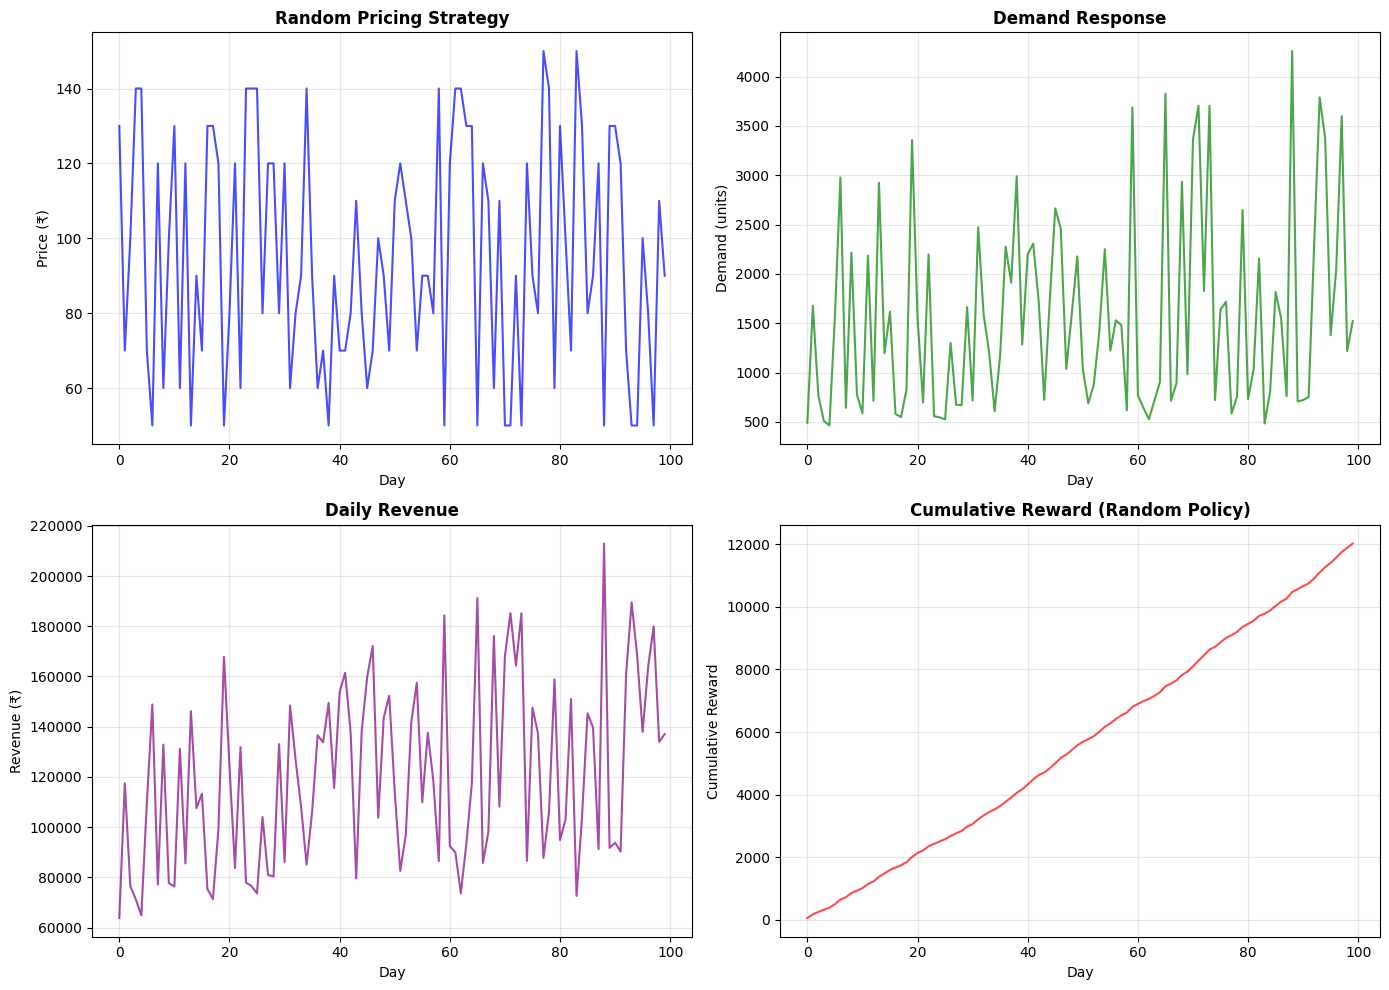

✅ Environment testing complete! Ready for agent training.


In [6]:
# Visualize random policy performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Prices over time
axes[0, 0].plot(prices, color='blue', alpha=0.7)
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Price (₹)')
axes[0, 0].set_title('Random Pricing Strategy', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Demand over time
axes[0, 1].plot(demands, color='green', alpha=0.7)
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Demand (units)')
axes[0, 1].set_title('Demand Response', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Revenue over time
axes[1, 0].plot(revenues, color='purple', alpha=0.7)
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Revenue (₹)')
axes[1, 0].set_title('Daily Revenue', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative reward
axes[1, 1].plot(np.cumsum(rewards), color='red', alpha=0.7)
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Cumulative Reward')
axes[1, 1].set_title('Cumulative Reward (Random Policy)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Environment testing complete! Ready for agent training.")